**Graph Embeddings** 

Graph-Embedding ist ein Ansatz, der verwendet wird, um Knoten, Kanten und deren Merkmale in einen Vektorraum (eine niedrigere Dimension) zu transformieren, während Eigenschaften wie die Graphstruktur und Informationen maximal erhalten bleiben.

**DeepWalk** ist ein Algorithmus, der verwendet wird, um Einbettungen der Knoten in einem Graphen zu erstellen. Die Einbettungen sollen die Gemeinschaftsstruktur des Graphen kodieren. Dies wird erreicht, indem SkipGram zur Erstellung der Einbettungen verwendet wird. DeepWalk nutzt kurze zufällige Spaziergänge, um Darstellungen für die Knoten in Graphen zu lernen.


**Node2Vec** ist ein Framework, das niederdimensionale Repräsentationen für Knoten in einem Graphen lernt, indem es ein nachbarschaftserhaltendes Ziel optimiert. Der Algorithmus simuliert zufällige Spaziergänge, um verschiedene Definitionen von Netzwerknachbarschaften zu berücksichtigen. Er bietet eine Möglichkeit, den Exploration-Exploitation-Tradeoff auszubalancieren, was zu Repräsentationen führt, die ein Spektrum von Äquivalenz von Homophilie bis struktureller Äquivalenz einhalten.

In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Importieren der CSV-Datei, in der die Kantenliste gespeichert ist (durch Kommas getrennt)
edge_list = pd.read_csv("graph_edges.csv", sep = ',', header = None)

In [5]:
# Überprüfen der ersten fünf Zeilen des DataFrames
edge_list.head()

,0,1
0,Source,Target
1,1,2
2,1,3
3,1,4
4,1,18


In [6]:
# Umbenennung der Spalten des DataFrames
edge_list.rename(columns = {0:'source', 1: 'target'}, inplace = True) # Durch den Parameter inplace=True wird die Änderung direkt im bestehenden DataFrame vorgenommen, ohne dass ein neues DataFrame erstellt wird.

In [7]:
# Entfernen der ersten Zeile im DataFrame
edge_list.drop(index=0, inplace = True)

In [8]:
edge_list.head()

,source,target
1,1,2
2,1,3
3,1,4
4,1,18
5,1,20


In [9]:
# Umwandlung der Ganzzahlen in Strings
edge_list = edge_list.applymap(str)

**Creation of graph:**

In [10]:
# Erstellen eines ungerichteten Graphen aus der Kantenliste
G=nx.from_pandas_edgelist(edge_list, source='source', target='target', create_using=nx.Graph())

In [11]:
# Ausgabe der Anzahl der Knoten und der Kanten im Graphen
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 34
Number of edges: 36


In [12]:
# Anzeige der Knoten im Graphen
G.nodes

NodeView(('1', '2', '3', '4', '18', '20', '22', '8', '9', '14', '13', '5', '6', '11', '7', '17', '10', '16', '23', '12', '31', '29', '15', '21', '27', '19', '24', '26', '25', '28', '32', '30', '34', '33'))

**Deep Walk Basics**

In [13]:
# Funktion zur Generierung von Zufallswanderungssequenzen von Knoten für einen bestimmten Knoten
def get_random_walk(node, walk_length):
    # Initialisierung der Zufallswanderung mit dem Startknoten
    random_walk_length = [node]
    
    # Schleife zur Erfassung der besuchten Knoten in einer Zufallswanderung
    for i in range(walk_length - 1):
        # Liste der Nachbarn des aktuellen Knotens
        neighbors = list(G.neighbors(node))
        # Entfernen der bereits besuchten Nachbarn aus der Nachbar-Liste
        neighbors = list(set(neighbors) - set(random_walk_length))    
        
        if len(neighbors) == 0:
            break  # Abbrechen, wenn keine neuen Nachbarn vorhanden sind
        
        # Zufällig einen Nachbarn aus der Liste der Nachbarn auswählen
        random_neighbor = random.choice(neighbors)
        # Den zufälligen Nachbarn zur Liste der Zufallswanderung hinzufügen
        random_walk_length.append(random_neighbor)
        node = random_neighbor  # Wechseln zum ausgewählten Nachbarn
        
    return random_walk_length

In [14]:
# Zufallswanderung für den Knoten '2' mit einer Länge von 10 überprüfen
get_random_walk('2', 10)

['2', '1', '20', '9', '3', '14', '29']

In [15]:
# Berechnung der Zufallswanderungen für jeden Knoten im Graphen
all_nodes = list(G.nodes())  # Liste aller Knoten im Graphen erstellen
number_of_random_walks = 5  # Anzahl der Zufallswanderungen pro Knoten festlegen
random_walks = []  # Liste zur Speicherung aller Zufallswanderungssequenzen initialisieren

for node in tqdm(all_nodes):  # Fortschrittsanzeige für die Schleife über alle Knoten
    # Anzahl der Zufallswanderungen
    for i in range(number_of_random_walks):
        # Hinzufügen der Zufallswanderungssequenz eines Knotens mit einer festgelegten Länge
        random_walks.append(get_random_walk(node, 10))

100%|██████████| 34/34 [00:00<00:00, 7597.97it/s]


In [16]:
# Länge der Liste der Zufallswanderungen überprüfen
len(random_walks)

170

In [17]:
# Anzeige der ersten Zufallswanderungssequenz
random_walks[0]

['1', '20', '9', '10', '16', '23']

In [18]:
# Anzeige der zweiten Zufallswanderungssequenz
random_walks[1]

['1', '22']

In [19]:
# Trainiere das Word2Vec-Modell
model = Word2Vec(window=4, sg=1, hs=0,
                 negative=10,  # für negatives Sampling
                 alpha=0.03, min_alpha=0.0007)

# Baue den Wortschatz aus den Zufallswanderungen auf
model.build_vocab(random_walks, progress_per=2)

In [20]:
# Trainiere das Word2Vec-Modell mit den Zufallswanderungen
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)
'''total_examples=model.corpus_count gibt die Gesamtzahl der Beispiele im Korpus an, die beim Training verwendet werden.
epochs=20 legt die Anzahl der Trainingsdurchläufe (Epochen) fest, die das Modell durchlaufen soll.
report_delay=1 gibt an, dass der Fortschritt des Trainings nach jedem Schritt (oder jeder Epoche) gemeldet werden soll.'''

'total_examples=model.corpus_count gibt die Gesamtzahl der Beispiele im Korpus an, die beim Training verwendet werden.\nepochs=20 legt die Anzahl der Trainingsdurchläufe (Epochen) fest, die das Modell durchlaufen soll.\nreport_delay=1 gibt an, dass der Fortschritt des Trainings nach jedem Schritt (oder jeder Epoche) gemeldet werden soll.'

In [21]:
print(model)

Word2Vec<vocab=34, vector_size=100, alpha=0.03>


Um die **ähnlichsten Knoten** in einem Word2Vec-Modell zu finden, kann man die Methode most_similar verwenden

In [22]:
# Ähnlichste Knoten zu Knoten '1' anzeigen
for node, _ in model.wv.most_similar('1'):
    print((node, _))

('31', 0.9989949464797974)
('8', 0.9988760948181152)
('2', 0.9988228678703308)
('13', 0.9988189935684204)
('20', 0.9987912178039551)
('18', 0.9987399578094482)
('9', 0.9987145066261292)
('4', 0.9987074136734009)
('22', 0.9986878037452698)
('32', 0.9986485838890076)


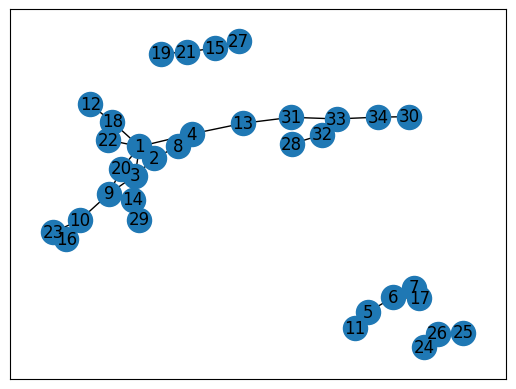

In [23]:
# Zeichnen des Netzwerks G mit NetworkX
nx.draw_networkx(G)

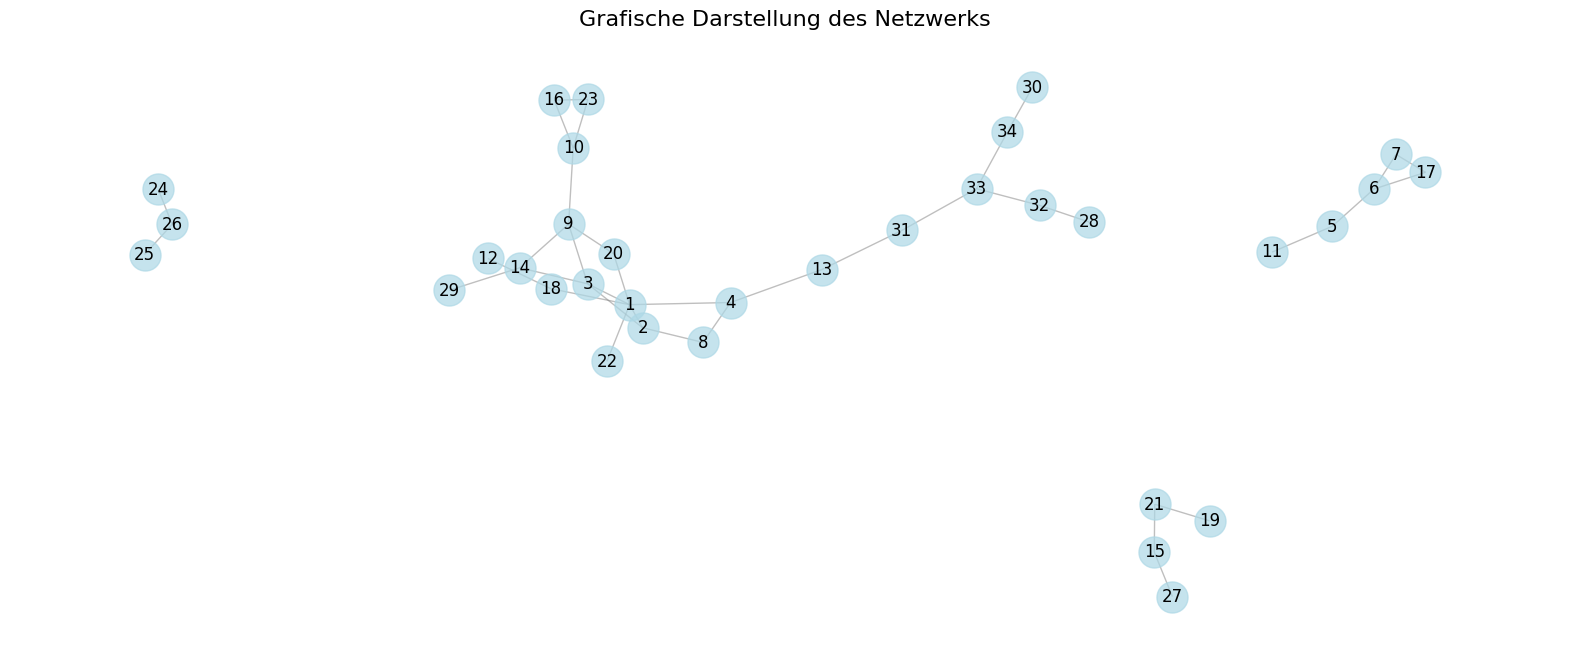

In [24]:
import matplotlib.pyplot as plt

# Zeichnen des Netzwerks G mit verbesserten Darstellungseinstellungen
plt.figure(figsize=(20, 8))  # Größe der Grafik festlegen
pos = nx.spring_layout(G)  # Positionen der Knoten im Graphen bestimmen

# Zeichnen der Knoten
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', alpha=0.7)

# Zeichnen der Kanten
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='gray')

# Zeichnen der Knotennamen
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

# Achsen ausschalten
plt.axis('off')

# Titel hinzufügen
plt.title("Grafische Darstellung des Netzwerks", fontsize=16)

# Zeigen der Grafik an
plt.show()

In [25]:
def plot_nodes(word_list):
    # Extraktion der Vektoren der angegebenen Wörter aus dem Word2Vec-Modell
    X = model.wv[word_list]
    
    # Reduzierung der Dimensionen auf 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    # Erstellung einer neuen Grafik
    plt.figure(figsize=(12, 9))
    # Erstellung eines Streudiagramms der Projektion
    plt.scatter(result[:, 0], result[:, 1])
    
    # Hinzufügen der Wörter als Beschriftungen
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
        
    # Anzeige der Grafik
    plt.show()

In [26]:
'''#Verbesserte Version der Visualisierung:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

def plot_nodes(word_list):
    # Extraktion der Vektoren der angegebenen Wörter aus dem Word2Vec-Modell
    X = model.wv[word_list]
    
    # Reduzierung der Dimensionen auf 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    # Erstellung einer neuen Grafik
    plt.figure(figsize=(18, 12))
    
    # Erstellung eines Streudiagramms der Projektion mit Farbskala
    scatter = plt.scatter(result[:, 0], result[:, 1], c=np.random.rand(len(word_list)), alpha=0.9, edgecolors='w')

    # Hinzufügen der Wörter als Beschriftungen
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=10, ha='center')
        
    # Hinzufügen eines Farbverlaufs
    plt.colorbar(scatter, label='Random Color Scale')

    # Achsenbeschriftungen hinzufügen
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    
    # Titel hinzufügen
    plt.title('2D Visualisierung der Wortvektoren', fontsize=16)

    # Anzeige der Grafik
    plt.grid(True)
    plt.show()'''

"#Verbesserte Version der Visualisierung:\nimport matplotlib.pyplot as plt\nfrom sklearn.decomposition import PCA\nimport numpy as np\n\ndef plot_nodes(word_list):\n    # Extraktion der Vektoren der angegebenen Wörter aus dem Word2Vec-Modell\n    X = model.wv[word_list]\n\n    # Reduzierung der Dimensionen auf 2\n    pca = PCA(n_components=2)\n    result = pca.fit_transform(X)\n\n    # Erstellung einer neuen Grafik\n    plt.figure(figsize=(18, 12))\n\n    # Erstellung eines Streudiagramms der Projektion mit Farbskala\n    scatter = plt.scatter(result[:, 0], result[:, 1], c=np.random.rand(len(word_list)), alpha=0.9, edgecolors='w')\n\n    # Hinzufügen der Wörter als Beschriftungen\n    for i, word in enumerate(word_list):\n        plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=10, ha='center')\n\n    # Hinzufügen eines Farbverlaufs\n    plt.colorbar(scatter, label='Random Color Scale')\n\n    # Achsenbeschriftungen hinzufügen\n    plt.xlabel('PCA Dimension 1')\n    plt.yla

In [27]:
# Liste der Knoten im Graphen in eine Liste umwandeln
numbers = list(G.nodes)

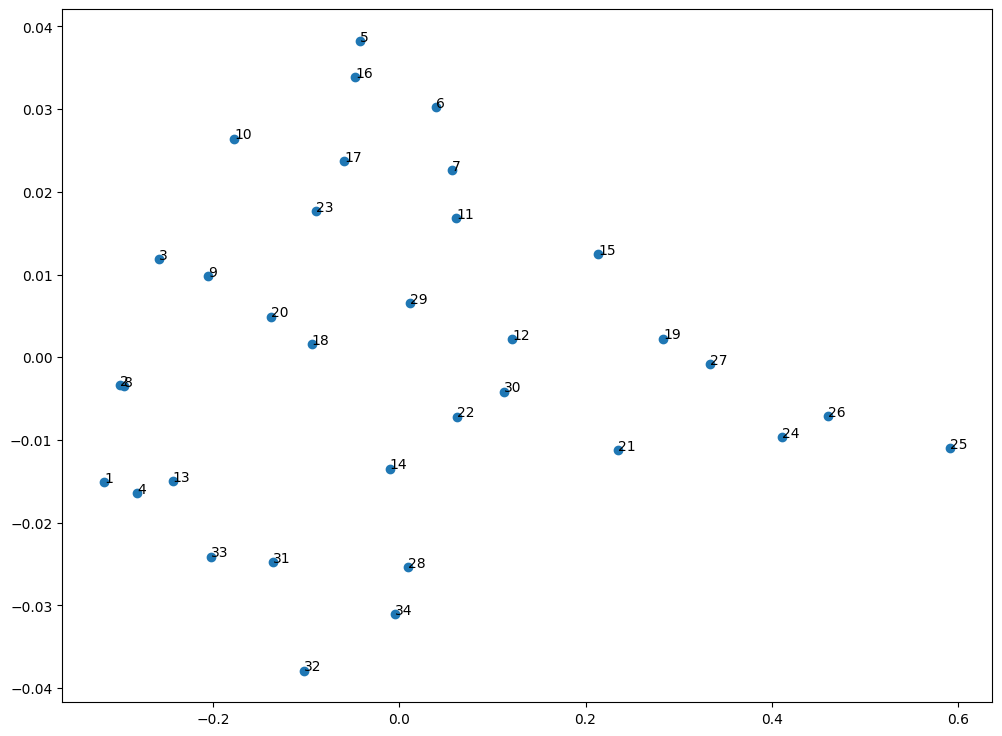

In [28]:
# Visualisierung der Knoten im Graphen mit der Funktion plot_nodes
plot_nodes(numbers)

**Node2Vec:**

In [29]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec

In [30]:
# Import der CSV-Datei:
edge_list = pd.read_csv('graph_edges.csv', sep = ',', header = None)

In [31]:
# Überprüfung der ersten fünf Zeilen des DataFrames
edge_list.head()

,0,1
0,Source,Target
1,1,2
2,1,3
3,1,4
4,1,18


In [32]:
# Entfernen der ersten Zeile im DataFrame
edge_list.drop(index=0, inplace=True)

In [33]:
# Umbenennung der Spalten des DataFrames
edge_list.rename(columns={0: 'source', 1: 'target'}, inplace=True)

In [34]:
# Überprüfung der Form des DataFrames
edge_list.shape

(36, 2)

In [35]:
# Erstellen eines ungerichteten Graphen aus der Kantenliste
G = nx.from_pandas_edgelist(edge_list, source='source', target='target', create_using=nx.Graph())

In [36]:
# Ausgabe der Anzahl der Knoten und der Kanten im Graphen
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 34
Number of edges: 36


In [37]:
# Abrufen der Namen der Knoten im Graphen
G.nodes

NodeView(('1', '2', '3', '4', '18', '20', '22', '8', '9', '14', '13', '5', '6', '11', '7', '17', '10', '16', '23', '12', '31', '29', '15', '21', '27', '19', '24', '26', '25', '28', '32', '30', '34', '33'))

In [38]:
# Vorberechnung der Wahrscheinlichkeiten und Generierung der Zufallswanderungen - **Funktioniert NUR unter WINDOWS mit workers=1**
node2vec = Node2Vec(G, dimensions=128, walk_length=40, num_walks=100, workers=2)

'''Diese Zeile erstellt ein Node2Vec-Objekt, das verwendet wird, um Knoten im Graphen G zu lernen und deren Vektorrepräsentationen zu erzeugen.
dimensions=128 legt die Dimensionen der Knotenvektoren fest, die erzeugt werden sollen.
walk_length=40 gibt die Länge jeder Zufallswanderung an.
num_walks=100 bestimmt die Anzahl der Zufallswanderungen, die für jeden Knoten durchgeführt werden.
workers=2 gibt die Anzahl der parallel verwendeten Prozesse an, um die Berechnung zu beschleunigen.'''

Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 9659.71it/s]


'Diese Zeile erstellt ein Node2Vec-Objekt, das verwendet wird, um Knoten im Graphen G zu lernen und deren Vektorrepräsentationen zu erzeugen.\ndimensions=128 legt die Dimensionen der Knotenvektoren fest, die erzeugt werden sollen.\nwalk_length=40 gibt die Länge jeder Zufallswanderung an.\nnum_walks=100 bestimmt die Anzahl der Zufallswanderungen, die für jeden Knoten durchgeführt werden.\nworkers=2 gibt die Anzahl der parallel verwendeten Prozesse an, um die Berechnung zu beschleunigen.'

In [39]:
# Einbetten der Knoten
model = node2vec.fit(window=10, min_count=1)

In [40]:
# Abrufen des Vektors für den Knoten '1'
vector_node_1 = model.wv.get_vector('1')

Um **die ähnlichsten Knoten** zu einem bestimmten Knoten im Node2Vec-Modell zu finden, kann die Methode most_similar verwendet werden.

In [41]:
# Ähnlichste Knoten zu Knoten '1' anzeigen
for node, _ in model.wv.most_similar('1'):
    print((node, _))

('2', 0.9204903841018677)
('22', 0.9133512377738953)
('8', 0.8963615894317627)
('20', 0.8858102560043335)
('3', 0.8854794502258301)
('18', 0.8684983849525452)
('4', 0.8537342548370361)
('12', 0.8307697176933289)
('9', 0.827937126159668)
('14', 0.7638718485832214)


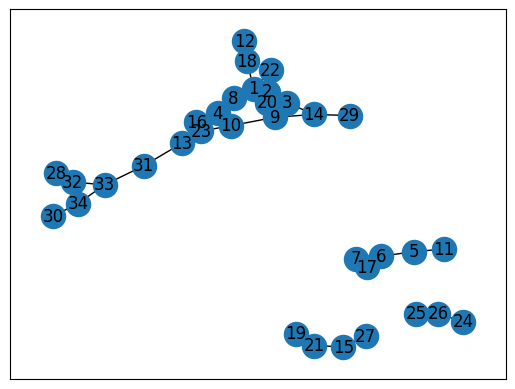

In [42]:
# Überprüfung der ähnlichsten Knoten, die von Node2Vec aus dem Graphen generiert wurden
nx.draw_networkx(G)

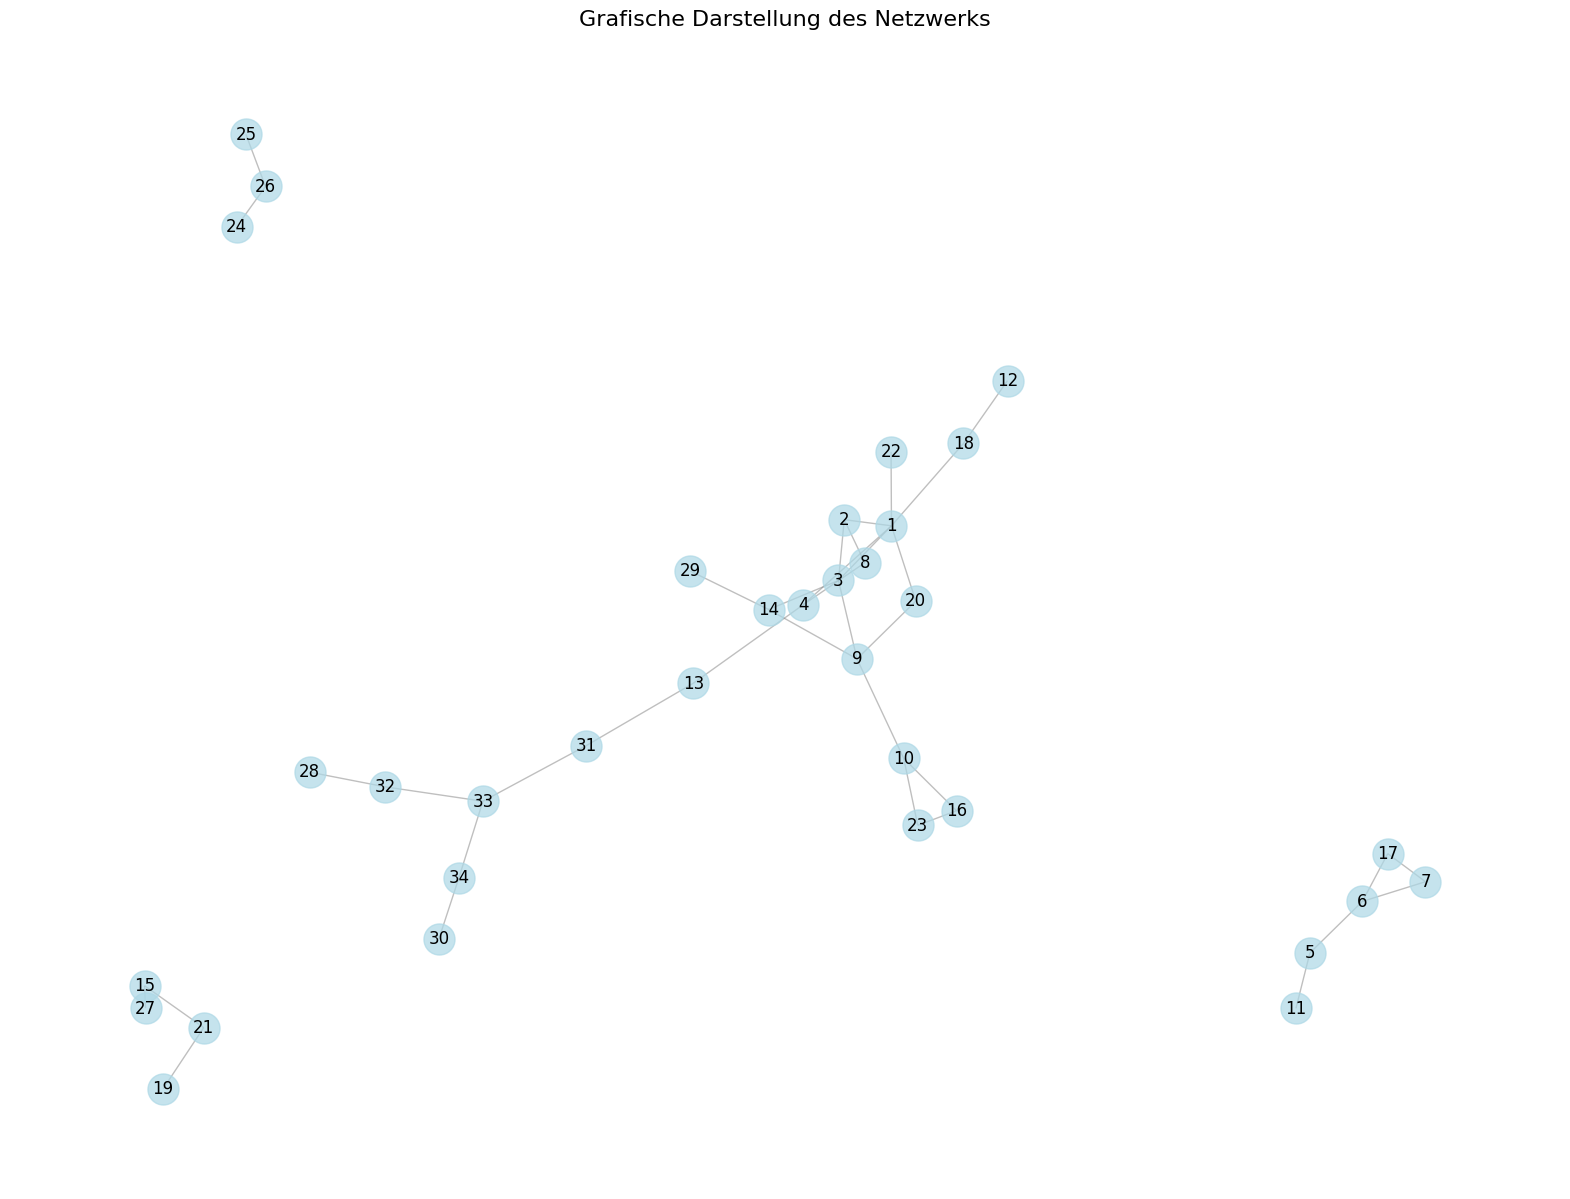

In [43]:
# Verbessere die Darstellung des Netzwerks G
plt.figure(figsize=(20, 15))  # Größe der Grafik festlegen
pos = nx.spring_layout(G)  # Positionen der Knoten im Graphen bestimmen

# Zeichnen der Knoten
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', alpha=0.7)

# Zeichnen der Kanten
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='gray')

# Zeichnen der Knotennamen
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

# Achsen ausschalten
plt.axis('off')

# Titel hinzufügen
plt.title("Grafische Darstellung des Netzwerks", fontsize=16)

# Zeigen der Grafik an
plt.show()

In [44]:
# Speichern der Knoten-Einbettungen im Word2Vec-Format
model.wv.save_word2vec_format('embedding.csv')

In [45]:
# Speichern des Modells für die spätere Verwendung
model.save('model')

Um alle Knoten-Einbettungen aus einem trainierten Node2Vec-Modell abzurufen, kann die folgende Methode verwendet werden:

In [46]:
# Abrufen der Knoten-Einbettungen
node_ids = model.wv.index_to_key  # Liste der Knoten-IDs
node_embeddings = model.wv.vectors  # Vektoren der Knoten-Einbettungen

In [47]:
# Ausgabe der Knoten-IDs
print(node_ids)

# Ausgabe der Knoten-Einbettungen
print(node_embeddings)

['1', '3', '9', '26', '6', '33', '21', '15', '4', '10', '2', '14', '34', '17', '7', '32', '5', '31', '13', '18', '8', '23', '16', '20', '25', '24', '27', '19', '30', '28', '11', '12', '22', '29']
[[-0.00960958  0.02937434 -0.02598389 ... -0.1833979  -0.15107144
   0.22123848]
 [ 0.05543626 -0.02492072  0.03572161 ... -0.11533506 -0.15253729
   0.19034638]
 [ 0.13188984 -0.04306024  0.0433136  ...  0.01985456 -0.12211159
   0.18476664]
 ...
 [-0.12633336  0.23511365 -0.03864449 ... -0.41095498 -0.16440164
   0.16337132]
 [-0.04802603  0.02751293 -0.14796887 ... -0.21349911 -0.12919487
   0.16196859]
 [ 0.06511308 -0.09505545  0.13025887 ... -0.00930118 -0.09230956
   0.18008703]]


**Anwendungsfall: Knoten-Einbettungen für Clustering**

Einbettungen können in verschiedenen nachgelagerten Aufgaben verwendet werden, wie zum Beispiel:

1. **Klassifikation:**	Verwendung von Einbettungen zur Klassifizierung von Knoten 
2. **Link-Vorhersage:**	Vorhersage fehlender Kanten zwischen Knoten basierend auf ihren 
3. **Clustering:**	Gruppierung von Knoten basierend auf Ähnlichkeiten in ihren Einbettungen
4. **Empfehlungen:**	Nutzung von Einbettungen zur Generierung von
5. **Anomalieerkennung:**	Identifikation von ungewöhnlichen Knoten oder Verbindungen



In [48]:
import warnings
from text_unidecode import unidecode
from collections import deque
warnings.filterwarnings('ignore')
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_style('whitegrid')

In [49]:
# Laden der Daten aus der CSV-Datei und Auswahl bestimmter Spalten
data = pd.read_csv('FullData.csv', usecols=['Name', 'Club', 'Club_Position', 'Rating'])

# Anzeige der ersten 10 Zeilen des DataFrames
data.head(10)

,Name,Club,Club_Position,Rating
0,Cristiano Ronaldo,Real Madrid,LW,94
1,Lionel Messi,FC Barcelona,RW,93
2,Neymar,FC Barcelona,LW,92
3,Luis Suárez,FC Barcelona,ST,92
4,Manuel Neuer,FC Bayern,GK,92
5,De Gea,Manchester Utd,GK,90
6,Robert Lewandowski,FC Bayern,ST,90
7,Gareth Bale,Real Madrid,RW,90
8,Zlatan Ibrahimović,Manchester Utd,ST,90
9,Thibaut Courtois,Chelsea,GK,89


**Pre-processing steps**

In [50]:
# Umwandlung der Spaltennamen in Kleinbuchstaben zur Vereinfachung
data.columns = list(map(str.lower, data.columns))

In [51]:
# Umformatierung von Strings: Kleinbuchstaben, ' ' -> '_', und é, ô usw. -> e, o
reformat_string = lambda x: unidecode(str.lower(x).replace(' ', '_'))

In [52]:
# Anwendung der Umformatierungsfunktion auf die Spalten 'name' und 'club'
data['name'] = data['name'].apply(reformat_string)
data['club'] = data['club'].apply(reformat_string)

In [53]:
# Umwandlung der Positionsbezeichnungen in Kleinbuchstaben
data['club_position'] = data['club_position'].str.lower()

In [54]:
# Ignoriere Ersatzspieler und Reservisten
data = data[(data['club_position'] != 'sub') & (data['club_position'] != 'res')]

'''In dieser Zeile wird der DataFrame data gefiltert, um alle Zeilen zu entfernen, in denen die Spalte 'club_position' den Wert 'sub' (Ersatzspieler) oder 'res' (Reservisten) hat.
Der Filter & sorgt dafür, dass nur die Zeilen ausgewählt werden, die nicht diesen Bedingungen entsprechen.
Dadurch wird sichergestellt, dass nur relevante Spieler in der Analyse verbleiben, was die Qualität und Aussagekraft der Daten verbessert.'''

"In dieser Zeile wird der DataFrame data gefiltert, um alle Zeilen zu entfernen, in denen die Spalte 'club_position' den Wert 'sub' (Ersatzspieler) oder 'res' (Reservisten) hat.\nDer Filter & sorgt dafür, dass nur die Zeilen ausgewählt werden, die nicht diesen Bedingungen entsprechen.\nDadurch wird sichergestellt, dass nur relevante Spieler in der Analyse verbleiben, was die Qualität und Aussagekraft der Daten verbessert."

In [55]:
# Korrektur von Positionen: lcm und rcm zu cm, sowie andere Anpassungen
fix_positions = {'rcm': 'cm', 'lcm': 'cm', 'rcb': 'cb', 'lcb': 'cb', 'ldm': 'cdm', 'rdm': 'cdm'}
data['club_position'] = data['club_position'].apply(lambda x: fix_positions.get(x, x))

In dieser Zeile wird ein Dictionary fix_positions definiert, das bestimmte Positionen auf ihre Standardbezeichnungen korrigiert.
Die Methode apply wird verwendet, um die Korrekturen auf die Spalte 'club_position' des data DataFrames anzuwenden.
fix_positions.get(x, x) sucht den aktuellen Positionswert x im Dictionary und ersetzt ihn durch den zugehörigen Wert, falls vorhanden. Wenn der Wert nicht gefunden wird, bleibt er unverändert.
Diese Korrekturen verbessern die Konsistenz der Positionsbezeichnungen und erleichtern die Analyse und das Verständnis der Daten.

In [56]:
data.head(10)

,name,club,club_position,rating
0,cristiano_ronaldo,real_madrid,lw,94
1,lionel_messi,fc_barcelona,rw,93
2,neymar,fc_barcelona,lw,92
3,luis_suarez,fc_barcelona,st,92
4,manuel_neuer,fc_bayern,gk,92
5,de_gea,manchester_utd,gk,90
6,robert_lewandowski,fc_bayern,st,90
7,gareth_bale,real_madrid,rw,90
8,zlatan_ibrahimovic,manchester_utd,st,90
9,thibaut_courtois,chelsea,gk,89


In [57]:
# Filtern des DataFrames nach bestimmten Clubs
clubs = {'real_madrid', 'manchester_utd', 
         'manchester_city', 'chelsea', 'juventus', 
         'fc_bayern', 'napoli'}

data = data[data['club'].isin(clubs)]

In [58]:
# Zeigen der Anzahl der Spieler pro Team an
player_counts = data.groupby('club')['name'].nunique()
print(player_counts)

club
chelsea            11
fc_bayern          11
juventus           11
manchester_city    11
manchester_utd     11
napoli             11
real_madrid        11
Name: name, dtype: int64


In [59]:
# Überprüfung, ob jede Mannschaft 11 Spieler hat
assert all(n_players == 11 for n_players in data.groupby('club')['name'].nunique())

**Formations of the teams**

Ein Dictionary FORMATIONS definiert, das verschiedene Fußballformationen für verschiedene Mannschaften beschreibt.

Jede Formation hat einen Schlüssel (z.B. '4-3-3_4', '5-2-2-1'), und jeder Schlüssel enthält ein weiteres Dictionary, das die Knotenpositionen (z.B. 'gk', 'lb', 'cm_1') und deren Verbindungen zu anderen Positionen enthält.

Diese Struktur ermöglicht es, die Positionen der Spieler innerhalb der Formationen und ihre Beziehungen zueinander zu definieren, was für Analysen oder Simulationen im Kontext von Fußballspielen nützlich sein kann.

In [60]:
FORMATIONS = {'4-3-3_4': {'gk': ['cb_1', 'cb_2'],                           # Real madrid
                          'lb': ['lw', 'cb_1', 'cm_1'],
                          'cb_1': ['lb', 'cb_2', 'gk'],
                          'cb_2': ['rb', 'cb_1', 'gk'],
                          'rb': ['rw', 'cb_2', 'cm_2'],
                          'cm_1': ['cam', 'lw', 'cb_1', 'lb'],
                          'cm_2': ['cam', 'rw', 'cb_2', 'rb'],
                          'cam': ['cm_1', 'cm_2', 'st'],
                          'lw': ['cm_1', 'lb', 'st'],
                          'rw': ['cm_2', 'rb', 'st'],
                          'st': ['cam', 'lw', 'rw']},
              '5-2-2-1': {'gk': ['cb_1', 'cb_2', 'cb_3'],                   # Chelsea
                          'cb_1': ['gk', 'cb_2', 'lwb'],
                          'cb_2': ['gk', 'cb_1', 'cb_3', 'cm_1', 'cb_2'],
                          'cb_3': ['gk', 'cb_2', 'rwb'],
                          'lwb': ['cb_1', 'cm_1', 'lw'],
                          'cm_1': ['lwb', 'cb_2', 'cm_2', 'lw', 'st'],
                          'cm_2': ['rwb', 'cb_2', 'cm_1', 'rw', 'st'],
                          'rwb': ['cb_3', 'cm_2', 'rw'],
                          'lw': ['lwb', 'cm_1', 'st'],
                          'st': ['lw', 'cm_1', 'cm_2', 'rw'],
                          'rw': ['st', 'rwb', 'cm_2']},
              '4-3-3_2': {'gk': ['cb_1', 'cb_2'],                           # Man UTD / CITY
                          'lb': ['cb_1', 'cm_1'],
                          'cb_1': ['lb', 'cb_2', 'gk', 'cdm'],
                          'cb_2': ['rb', 'cb_1', 'gk', 'cdm'],
                          'rb': ['cb_2', 'cm_2'],
                          'cm_1': ['cdm', 'lw', 'lb', 'st'],
                          'cm_2': ['cdm', 'rw', 'st', 'rb'],
                          'cdm': ['cm_1', 'cm_2', 'cb_1', 'cb_2'],
                          'lw': ['cm_1', 'st'],
                          'rw': ['cm_2', 'st'],
                          'st': ['cm_1', 'cm_2', 'lw', 'rw']},              # Juventus, Bayern
                            '4-2-3-1_2': {'gk': ['cb_1', 'cb_2'],
                            'lb': ['lm', 'cdm_1', 'cb_1'],
                            'cb_1': ['lb', 'cdm_1', 'gk', 'cb_2'],
                            'cb_2': ['rb', 'cdm_2', 'gk', 'cb_1'],
                            'rb': ['cb_2', 'rm', 'cdm_2'],
                            'lm': ['lb', 'cdm_1', 'st', 'cam'],
                            'rm': ['rb', 'cdm_2', 'st', 'cam'],
                            'cdm_1': ['lm', 'cb_1', 'rb', 'cam'],
                            'cdm_2': ['rm', 'cb_2', 'lb', 'cam'],
                            'cam': ['cdm_1', 'cdm_2', 'rm', 'lm', 'st'],
                            'st': ['lm', 'rm', 'cam']},
              '4-3-3': {'gk': ['cb_1', 'cb_2'],                             # Napoli
                        'lb': ['cb_1', 'cm_1'],
                        'cb_1': ['lb', 'cb_2', 'gk', 'cm_2'],
                        'cb_2': ['rb', 'cb_1', 'gk', 'cm_2'],
                        'rb': ['cb_2', 'cm_3'],
                        'cm_1': ['cm_2', 'lw', 'lb'],
                        'cm_3': ['cm_2', 'rw', 'rb'],
                        'cm_2': ['cm_1', 'cm_3', 'st', 'cb_1', 'cb_2'],
                        'lw': ['cm_1', 'st'],
                        'rw': ['cm_3', 'st'],
                        'st': ['cm_2', 'lw', 'rw']}}

**Creation of graph**

In [61]:
add_club_suffix = lambda x, c: x + '_{}'.format(c)

graph = nx.Graph()
formatted_positions = set()

def club2graph(club_name, formation, graph):
    # Filtern der Daten für den spezifischen Club
    club_data = data[data['club'] == club_name]
    
    # Abrufen der spezifischen Formation aus dem FORMATIONS-Dictionary
    club_formation = FORMATIONS[formation]
    
    # Wörterbuch zur Speicherung der zugewiesenen Spieler und Positionen
    roster = dict()

    # Initialisierung der verfügbaren Positionen
    available_positions = deque(club_formation)  
    available_players = set(zip(club_data['name'], club_data['club_position']))
    
    while available_positions:
        position = available_positions.pop()
        # Finden eines Spielers, der zur Position passt
        name, pos = [(name, position) for name, p in available_players if position.startswith(p)][0]        
        
        roster[name] = pos
        
        # Entfernen des Spielers aus der Liste der verfügbaren Spieler
        available_players.remove((name, pos.split('_')[0]))
        
    # Umkehren des Rosters für die Verbindungen
    reverse_roster = {v: k for k, v in roster.items()}
    
    # Aufbau des Graphen
    for name, position in roster.items():
        # Verbindung zum Teamnamen
        graph.add_edge(name, club_name)
        
        # Interne Teamverbindungen
        for teammate_position in club_formation[position]:
            # Verbinden der Positionen
            graph.add_edge(add_club_suffix(position, club_name),
                           add_club_suffix(teammate_position, club_name))
            
            # Verbindung des Spielers zu den Positionen der Teamkollegen
            graph.add_edge(name,
                           add_club_suffix(teammate_position, club_name))
            
            # Verbindung des Spielers zu Teamkollegen
            graph.add_edge(name, reverse_roster[teammate_position])
            
            # Speichern für spätere Anpassungen
            formatted_positions.add(add_club_suffix(position, club_name))
            formatted_positions.add(add_club_suffix(teammate_position, club_name))
            
    return graph

**Teams Mapping**

In [62]:
teams = [('real_madrid', '4-3-3_4'), 
         ('chelsea', '5-2-2-1'),
         ('manchester_utd', '4-3-3_2'),
         ('manchester_city', '4-3-3_2'),
         ('juventus', '4-2-3-1_2'),
         ('fc_bayern', '4-2-3-1_2'),
         ('napoli', '4-3-3')]

In [63]:
# Erstellung des Graphen für ein spezifisches Team
graph = club2graph('real_madrid', '4-3-3_4', graph)

In [64]:
# Erstellung von 7 Graphen, jeweils für ein Team
for team, formation in teams:
    graph = club2graph(team, formation, graph)

**Node2Vec**

In [65]:
# Erstellung des Node2Vec-Modells aus dem Graphen
node2vec = Node2Vec(graph, dimensions=20, walk_length=16, num_walks=100, workers=2)

Computing transition probabilities: 100%|██████████| 161/161 [00:00<00:00, 2578.41it/s]


**Ähnlichste Knoten**

In [66]:
# Funktion zur Korrektur der formatierten Positionen
fix_formatted_positions = lambda x: x.split('_')[0] if x in formatted_positions else x

# Umformatierte Zufallswanderungen erstellen
reformatted_walks = [list(map(fix_formatted_positions, walk)) for walk in node2vec.walks]

# Aktualisierung der Zufallswanderungen im Node2Vec-Modell
node2vec.walks = reformatted_walks

# Lernen der Einbettungen
model = node2vec.fit(window=10, min_count=1)

In [67]:
# Ähnlichste Knoten zu 'real_madrid' anzeigen
for node, _ in model.wv.most_similar('real_madrid'):
    print(node)

toni_kroos
james_rodriguez
sergio_ramos
carvajal
pepe
luka_modric
keylor_navas
karim_benzema
marcelo
gareth_bale


In [68]:
# Ähnlichste Knoten zu 'paulo_dybala' anzeigen
for node, _ in model.wv.most_similar('paulo_dybala'):
    print(node)

gonzalo_higuain
juan_cuadrado
mario_mandzukic
stephan_lichtsteiner
miralem_pjanic
sami_khedira
alex_sandro
juventus
leonardo_bonucci
giorgio_chiellini


**Visualization of the teams**

In [69]:
# Erstellen einer Liste von Spieler-Knoten, die länger als 3 Zeichen sind und nicht in den Clubs enthalten sind
player_nodes = [x for x in model.wv.key_to_index if len(x) > 3 and x not in clubs]

# Abrufen der Einbettungen für die Spieler-Knoten
embeddings = np.array([model.wv[x] for x in player_nodes]) #werden die Einbettungen für diese Spieler-Knoten in ein NumPy-Array embeddings konvertiert.
#Jede Einbettung entspricht dem Vektor, der dem jeweiligen Spieler im trainierten Modell zugeordnet ist.

In [70]:
# Anwendung von t-SNE zur Reduzierung der Dimensionen auf 2
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)

In [71]:
# Zuweisung von Farben zu Spielern basierend auf ihren Clubs
team_colors = {
    'real_madrid': 'lightblue',
    'chelsea': 'b',
    'manchester_utd': 'r',
    'manchester_city': 'teal',
    'juventus': 'gainsboro',
    'napoli': 'deepskyblue',
    'fc_bayern': 'tomato' 
}

# Hinzufügen einer Farbspalte zum DataFrame basierend auf dem Club
data['color'] = data['club'].apply(lambda x: team_colors[x])

# Erstellen eines Wörterbuchs zur Zuordnung von Spielernamen zu Farben
player_colors = dict(zip(data['name'], data['color']))

# Abrufen der Farben für die Spieler-Knoten
colors = [player_colors[x] for x in player_nodes]

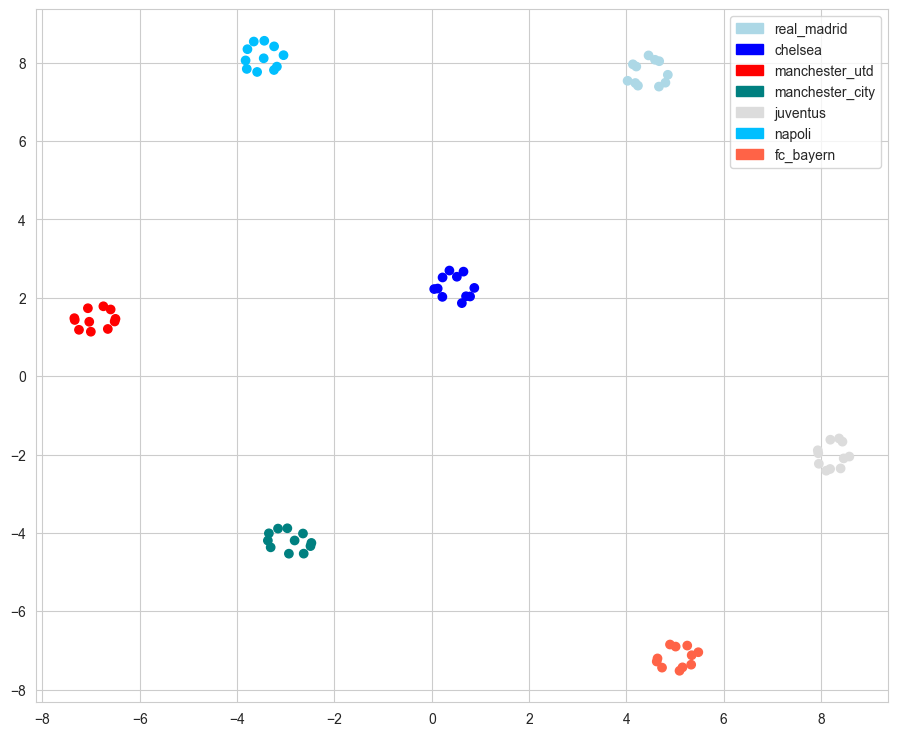

In [72]:
# Erstellung der Figur für die Visualisierung
figure = plt.figure(figsize=(11, 9))

# Hinzufügen eines 2D-Subplots zur Figur
ax = figure.add_subplot(111)

# Streudiagramm der 2D-Einbettungen mit Farben für die Spieler
ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)

# Erstellung der Team-Patches für die Legende
team_patches = [mpatches.Patch(color=color, label=team) for team, color in team_colors.items()]

# Hinzufügen der Legende zum Diagramm
ax.legend(handles=team_patches);

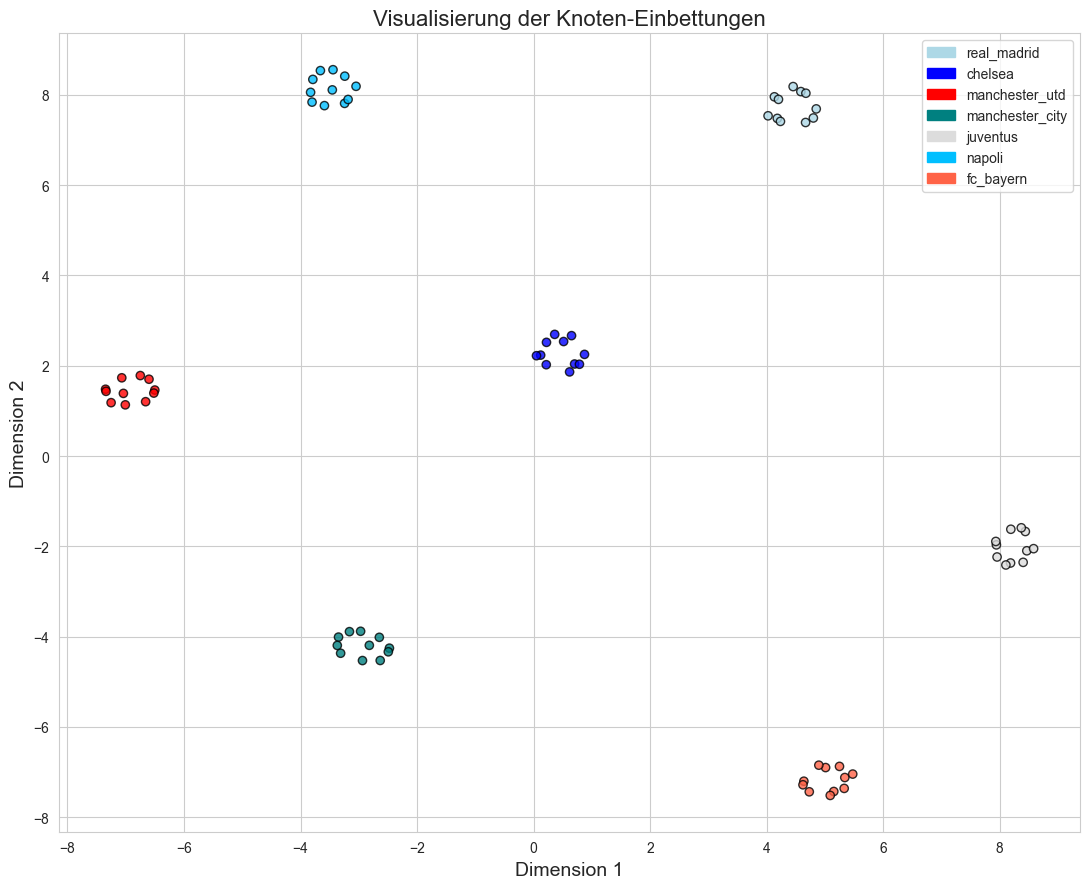

In [73]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Erstellung der Figur für die Visualisierung
figure = plt.figure(figsize=(11, 9))
ax = figure.add_subplot(111)

# Streudiagramm der 2D-Einbettungen mit Farben für die Spieler
scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.8, edgecolor='k')

# Erstellung der Team-Patches für die Legende
team_patches = [mpatches.Patch(color=color, label=team) for team, color in team_colors.items()]

# Hinzufügen der Legende zum Diagramm
ax.legend(handles=team_patches)

# Hinzufügen von Achsenbeschriftungen
ax.set_xlabel('Dimension 1', fontsize=14)
ax.set_ylabel('Dimension 2', fontsize=14)

# Hinzufügen eines Titels
ax.set_title('Visualisierung der Knoten-Einbettungen', fontsize=16)

# Aktivierung des Gitters für bessere Lesbarkeit
ax.grid(True)

# Anpassung der Layout-Elemente
plt.tight_layout()

# Anzeige der Grafik
plt.show()

**Modelltraining mit Klassifizierungsalgorithmen auf Basis von Knoten-Einbettungen**

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import joblib

**Datenvorbereitung:**
1. Einbettungen abrufen
2. Labels hinzufügen

In [75]:
print(len(player_nodes))         # Anzahl der Knoten-IDs
print(embeddings.shape)      # Shape der Einbettungen (muss (Anzahl der Knoten, Dimension) sein)

77
(77, 20)


In [76]:
# Beispiel: Erstellen eines DataFrames mit den Einbettungen und den zugehörigen Labels
embeddings_df = pd.DataFrame(embeddings, index=player_nodes)  # Knoten-Einbettungen in DataFrame umwandeln
embeddings_df['label'] = [data.loc[data['name'] == node, 'club'].values[0] for node in player_nodes]  # Beispiel für Labels

**Datenaufteilung:**

Teilen der Daten in Trainings- und Testdatensätze auf. 

In [77]:
X = embeddings_df.drop('label', axis=1)  # Merkmale (Einbettungen)
y = embeddings_df['label']  # Zielvariable (Labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80/20 Aufteilung

In [ ]:
# Überprüfung, ob die Trainings- und Testdatensätze unabhängig sind

# Die Funktion 'intersection' gibt die gemeinsamen Indizes zwischen den beiden Datensätzen zurück.
# Wenn die Trainings- und Testdatensätze korrekt aufgeteilt wurden, sollte es keine gemeinsamen Indizes geben,
# d.h. die Ergebnisse der 'intersection'-Funktion sollten leer sein.

# Die 'assert'-Anweisung überprüft, ob die Bedingung wahr ist. Wenn die Bedingung wahr ist, geschieht nichts 
# und das Programm läuft weiter. Wenn die Bedingung falsch ist, wirft die Anweisung einen AssertionError.

# In diesem Fall, wenn die 'intersection'-Funktion ein leeres Ergebnis zurückgibt (was bedeutet, dass es keine
# gemeinsamen Indizes gibt), ist die Bedingung wahr und das Programm läuft weiter.

# Wenn die 'intersection'-Funktion nicht leer ist (was bedeutet, dass es gemeinsame Indizes gibt), ist die 
# Bedingung falsch und ein AssertionError wird geworfen. Dies würde darauf hindeuten, dass die Trainings- und 
# Testdatensätze nicht korrekt aufgeteilt wurden.


assert X_train.index.intersection(X_test.index).empty
assert y_train.index.intersection(y_test.index).empty

In [ ]:
print(X_train.columns)
print(X_test.columns)

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='object')
Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='object')


**Modellwahl:**
Wählen eines Klassifizierungsalgorithmuses aus: Logistic Regression, Random Forest, Support Vector Machine (SVM), oder ein neuronales Netzwerk.

In [83]:
from sklearn.linear_model import LogisticRegression
# Erstellung und Training des Logistischen Regressionsmodells
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

LogisticRegression()

In [85]:
# Vorhersagen für den gesamten Datensatz
predictions = model_lr.predict(X_train)

In [86]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Erstellen der Konfusionsmatrix
conf_matrix = confusion_matrix(y_train, predictions)

In [87]:
# Überprüfen der Zielvariable
print(y_train.unique())  # Einzigartige Werte in y_train

# Vorhersagen für die Trainingsdaten
predictions = model_lr.predict(X_train)  # Vorhersagen mit dem trainierten Modell

# Überprüfen der Vorhersagen
print(np.unique(predictions))  # Einzigartige Vorhersagewerte

['manchester_utd' 'napoli' 'real_madrid' 'fc_bayern' 'juventus' 'chelsea'
 'manchester_city']
['chelsea' 'fc_bayern' 'juventus' 'manchester_city' 'manchester_utd'
 'napoli' 'real_madrid']


In [88]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Erstellung der Konfusionsmatrix
conf_matrix = confusion_matrix(y_train, predictions)

# Berechnung der Gütekriterien
accuracy = accuracy_score(y_train, predictions)  # Genauigkeit des Modells
precision = precision_score(y_train, predictions, average='weighted')  # Präzision
recall = recall_score(y_train, predictions, average='weighted')  # Rückruf
f1 = f1_score(y_train, predictions, average='weighted')  # F1-Score

In [89]:
print(accuracy, precision, recall, f1)

1.0 1.0 1.0 1.0


In [90]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_lr, X_train, y_train, cv=5)
print("Cross-validation scores: ", scores)

Cross-validation scores:  [1. 1. 1. 1. 1.]


In [91]:
model_lr = LogisticRegression(C=0.1)  # kleinerer Wert für C bedeutet stärkere Regularisierung
model_lr.fit(X_train, y_train)

LogisticRegression(C=0.1)

In [92]:
predictions_test = model_lr.predict(X_test)
accuracy_test = accuracy_score(y_test, predictions_test)
print("Test accuracy: ", accuracy_test)

Test accuracy:  1.0


In [ ]:
print(y_train.value_counts())

manchester_city    9
napoli             9
juventus           9
real_madrid        9
manchester_utd     9
chelsea            8
fc_bayern          8
Name: label, dtype: int64


**Gradient Boosting**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
predictions_gb = gb_model.predict(X_test)
predictions_gb

array(['napoli', 'juventus', 'fc_bayern', 'napoli', 'fc_bayern',
       'real_madrid', 'manchester_city', 'fc_bayern', 'chelsea',
       'chelsea', 'manchester_utd', 'real_madrid', 'manchester_city',
       'manchester_utd', 'chelsea', 'juventus'], dtype=object)

In [ ]:
print(classification_report(y_test, predictions_gb))

                 precision    recall  f1-score   support

        chelsea       1.00      1.00      1.00         3
      fc_bayern       1.00      1.00      1.00         3
       juventus       1.00      1.00      1.00         2
manchester_city       1.00      1.00      1.00         2
 manchester_utd       1.00      1.00      1.00         2
         napoli       1.00      1.00      1.00         2
    real_madrid       1.00      1.00      1.00         2

       accuracy                           1.00        16
      macro avg       1.00      1.00      1.00        16
   weighted avg       1.00      1.00      1.00        16



Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
predictions_svm = svm_model.predict(X_test)
print(classification_report(y_test, predictions_svm))

                 precision    recall  f1-score   support

        chelsea       1.00      1.00      1.00         3
      fc_bayern       1.00      1.00      1.00         3
       juventus       1.00      1.00      1.00         2
manchester_city       1.00      1.00      1.00         2
 manchester_utd       1.00      1.00      1.00         2
         napoli       1.00      1.00      1.00         2
    real_madrid       1.00      1.00      1.00         2

       accuracy                           1.00        16
      macro avg       1.00      1.00      1.00        16
   weighted avg       1.00      1.00      1.00        16



**K-nearest Neighbors (KNN)**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
predictions_knn = knn_model.predict(X_test)
print(classification_report(y_test, predictions_knn))

                 precision    recall  f1-score   support

        chelsea       1.00      1.00      1.00         3
      fc_bayern       1.00      1.00      1.00         3
       juventus       1.00      1.00      1.00         2
manchester_city       1.00      1.00      1.00         2
 manchester_utd       1.00      1.00      1.00         2
         napoli       1.00      1.00      1.00         2
    real_madrid       1.00      1.00      1.00         2

       accuracy                           1.00        16
      macro avg       1.00      1.00      1.00        16
   weighted avg       1.00      1.00      1.00        16



**Neurale Netzwerke**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(len(np.unique(y_train)), activation='softmax'))

nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train, y_train, epochs=10, batch_size=32)

ValueError: Invalid dtype: object

**Random Forest Classifier**

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)  # Beispiel: Random Forest
model.fit(X_train, y_train)  # Modell trainieren

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = model.predict(X_test)  # Vorhersagen für die Testdaten
print(classification_report(y_test, y_pred))  # Detaillierter Bericht
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")  # Genauigkeit ausgeben

                 precision    recall  f1-score   support

        chelsea       1.00      1.00      1.00         3
      fc_bayern       1.00      1.00      1.00         3
       juventus       1.00      1.00      1.00         2
manchester_city       1.00      1.00      1.00         2
 manchester_utd       1.00      1.00      1.00         2
         napoli       1.00      1.00      1.00         2
    real_madrid       1.00      1.00      1.00         2

       accuracy                           1.00        16
      macro avg       1.00      1.00      1.00        16
   weighted avg       1.00      1.00      1.00        16

Accuracy: 1.0


In [ ]:
param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [100, 200]})

In [ ]:
joblib.dump(model, 'trained_model.pkl')  # Modell speichern

['trained_model.pkl']